<a href="https://colab.research.google.com/github/TheeraphatKhiangphukhiao/trainflowermodel/blob/main/trainflowermodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***ทำการเชื่อมต่อ Google Drive เพื่อที่จะโหลดรูปภาพดอกไม้เข้ามาทำงาน***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***ทําการ import library สําหรับการสร้าง model***

In [ ]:
from numpy import unique
from numpy import argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [ ]:
from os import listdir
from os.path import isfile, join
from sklearn import preprocessing
from tqdm import tqdm
import os
import cv2
import numpy as np
import joblib

***ทำการกำหนด Path ที่เก็บข้อมูลรูปภาพดอกไม้***

In [ ]:
width = 28 # ทำการปรับขนาดความกว้างความสูงของรูปภาพทั้งหมดให้เป็น 128 x 128 Pixel
train_path = '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/'
test_path = '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/test/'

***ชุดข้อมูลจะประกอบไปด้วยภาพดอกไม้ 10 ประเภท ประกอบไปด้วยชุดข้อมูลที่เอาไว้ Train 9817 รูป เเละชุดข้อมูลที่เอาไว้ Test 70 รูป เเบ่งประเภทละ 10 รูป เเละรองรับการจดจำดอกไม้ประเภทต่อไปนี้ water_lily , tulip , sunflower , rose , iris , common_daisy , carnation , calendula , black_eyed_susan , bellflower***

In [ ]:
# ทำการอ่านจำนวนประเภทของดอกไม้ 10 ชนิดมาเก็บไว้ในตัวเเปร class_names ที่มีชนิดเป็น List
# ซึ่งชนิดของดอกไม้จะเป็นชื่อของ โฟลเดอร์ ที่เก็บรูปภาพไว้
class_names = []
for class_name in os.listdir(train_path):
  class_names.append(class_name) # นำชื่อ class ไปเก็บไว้ในตัวเเปร class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['water_lily', 'tulip', 'sunflower', 'rose', 'iris', 'common_daisy', 'carnation', 'calendula', 'black_eyed_susan', 'bellflower']
10


In [ ]:
# ทำการสร้าง Path ที่ชี้ไปยังโฟลเดอร์ที่เก็บรูปภาพเอาไว้ โดยผลลัพธ์จะได้เป็น List ที่เก็บ Path ของโฟลเดอร์ประเภทดอกไม้ 14 ชนิด
# เช่น /content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/water_lily หรือ /content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/tulip
train_img = [train_path+f for f in listdir(train_path) if listdir(join(train_path, f))]
test_img = [test_path+f for f in listdir(train_path) if listdir(join(test_path, f))]
print(train_img)
print(test_img)

['/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/water_lily', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/tulip', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/sunflower', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/rose', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/iris', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/common_daisy', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/carnation', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/calendula', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/black_eyed_susan', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/train/bellflower']
['/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/test/water_lily', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/test/tulip', '/content/drive/MyDrive/AI Deep Learning/AI Project/Dataset/test/sunf

In [ ]:
def img2Data(path):
  rawImgs = []
  labels = []
  c =0
  for imagePath in os.listdir(path):
    for item in tqdm(os.listdir(os.path.join(path,imagePath))):
      file = os.path.join(path, imagePath+"/"+item)
      c+=1
      labels.append([imagePath])

      img = cv2.imread(file, cv2.COLOR_BGR2RGB) # ทำการโหลดรูปภาพเข้ามา เป็นรูปภาพเเบบ RGB
      img = cv2.resize(img ,(width, width))
      assert img.shape == (width, width, 3), f"Invalid image shape for file: {file}"
      rawImgs.append(img)
  return rawImgs, labels

x_train, y_train = img2Data(train_path) # เรียกใช้ฟังก์ชัน img2Data เพื่อโหลดข้อมูลภาพจากไดเรกทอรี train_path เเละ test_path
x_test, y_test = img2Data(test_path)

100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


***ทำการเเปลงข้อมูล x_train, x_test, y_train, y_test ที่มีชนิดข้อมูลเป็น List ไปเป็น NumPyarrays***

In [ ]:
# ทำการเเปลงข้อมูล x_train, x_test, y_train, y_test ที่มีชนิดข้อมูลเป็น List ไปเป็น NumPyarrays
# เพื่อที่จะช่วยให้เราใช้ไลบรารี TensorFlow หรือ Keras ได้ง่ายขึ้น เนื่องจากเหมาะสมกับโครงสร้างของข้อมูลภาพใน TensorFlow/Keras
import numpy as np

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

***ทำการเเสดง จำนวนตัวอย่าง ความสูง ความกว้าง ช่องสี เเต่ในงานนี้มีช่องสี 3 สี ก็คือ RGB***

In [ ]:
# ทำการเเสดงขนาดของรูปออกมา
print(x_train.shape) # มี data 13648 มีขนาด 128 x 128
print(x_test.shape) # มี data 98 มีขนาด 128 x 128

(9817, 28, 28, 3)
(70, 28, 28, 3)


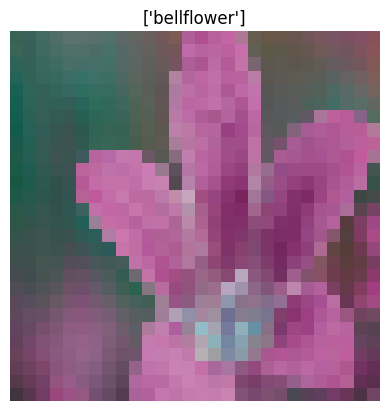

In [ ]:
# เเสดงรูปภาพออกมา
from matplotlib import pyplot as plt
def display_image(i):
  plt.imshow(x_train[i], cmap = 'gray')
  plt.title(y_train[i]) # เเสดง class ในที่นี้คือเลข 5
  plt.axis('off') # ไม่เเสดงเเกน

display_image(9800)

In [ ]:
class_name = unique(y_train)
print(class_name)

['bellflower' 'black_eyed_susan' 'calendula' 'carnation' 'common_daisy'
 'iris' 'rose' 'sunflower' 'tulip' 'water_lily']


***ทำการเข้ารหัสเเบบ Label Encoding เพื่อพยายามรักษาความหมายของ ประเภทดอกไม้ ที่เป็นข้อความ***

In [ ]:
#ทำการเเปลงประเภทดอกไม้ที่เป็นข้อความ ให้ไปเป็นตัวเลข
#สามารถแทนที่องค์ประกอบเหล่านี้ด้วย 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ที่เเทนความหมายของประเภทดอกไม้ เเต่ละชนิด
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_train

array([9, 9, 9, ..., 0, 0, 0])

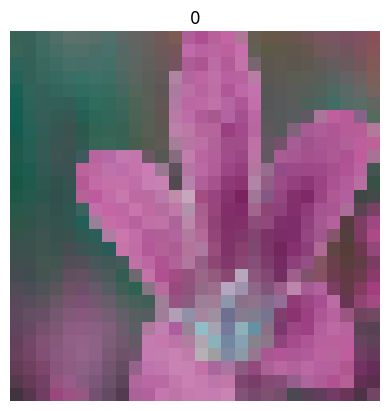

In [ ]:
# เเสดงรูปภาพออกมา
from matplotlib import pyplot as plt
def display_image(i):
  plt.imshow(x_train[i], cmap = 'gray')
  plt.title(y_train[i]) # เเสดง class ในที่นี้คือเลข 5
  plt.axis('off') # ไม่เเสดงเเกน

display_image(9800)

***ทําการพิจารณาขนาดของ Input***

In [ ]:
# determine the shape of the input images
in_shape = x_train.shape[1:]

***ทําการพิจารณาจํานวนคลาสของข้อมูล***

In [ ]:
# determine the number of classes

n_classes = len(unique(y_train))
print(in_shape, n_classes)

(28, 28, 3) 10


***เเสดงข้อมูล y_train ที่ผ่านกระบวนการ Label Encoding มาเเล้ว***

In [ ]:
unique_classes = np.unique(y_train) #โดยคำสั่ง unique จะเป็นการหาค่าที่ไม่ซํ้ากันในตัวเเปร y_train

print(unique_classes)

[0 1 2 3 4 5 6 7 8 9]


***ทําการ normalize pixel จากเดิมค่าอยู่ระหว่าง 0-255 ให้อยู่ในช่วง 0-1 เพื่อให้การประมวลผลนั้น ง่ายและเร็ว***

In [ ]:
# normalize pixel values

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print(x_train)

[[[[0.00784314 0.01568628 0.01568628]
   [0.00392157 0.01176471 0.01176471]
   [0.00784314 0.01568628 0.01568628]
   ...
   [0.05882353 0.07058824 0.08627451]
   [0.01568628 0.02352941 0.02352941]
   [0.01176471 0.01176471 0.01176471]]

  [[0.00784314 0.01568628 0.01568628]
   [0.01176471 0.01960784 0.02352941]
   [0.00784314 0.01568628 0.01568628]
   ...
   [0.06666667 0.08235294 0.08627451]
   [0.00784314 0.01568628 0.01568628]
   [0.         0.00784314 0.00784314]]

  [[0.01568628 0.02352941 0.02745098]
   [0.01176471 0.01960784 0.01960784]
   [0.01176471 0.01960784 0.01960784]
   ...
   [0.05490196 0.07450981 0.07843138]
   [0.00392157 0.01176471 0.01176471]
   [0.00392157 0.01176471 0.01176471]]

  ...

  [[0.6627451  0.7529412  0.74509805]
   [0.12156863 0.3254902  0.28627452]
   [0.03921569 0.10196079 0.06666667]
   ...
   [0.02745098 0.03529412 0.03921569]
   [0.02352941 0.03137255 0.03529412]
   [0.02745098 0.03529412 0.03921569]]

  [[0.01960784 0.02745098 0.02745098]
   [0.0

***ทําการสร้าง model***

In [ ]:
# define model

model = Sequential() # สร้าง Model เเบบ Sequential
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape)) # Convolutional Layer เป็นขั้นตอนแรกในกระบวนการดึงคุณลักษณะของ image
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape)) # Convolutional Layer เป็นขั้นตอนแรกในกระบวนการดึงคุณลักษณะของ image
model.add(MaxPooling2D((2, 2)))
model.add(Flatten()) # คือการเเปลงข้อมูลให้เป็น Array 1 D
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax')) # softmax จะทำให้ค่าที่ได้ไม่ติดลบ

***กําหนดรูปแบบการประมวลผล***

In [ ]:
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

***ทําการ Train model***

In [ ]:
# fit the model
model.fit(x_train, y_train, epochs=15, batch_size=128, verbose=1) # epochs=15 หมายถึงให้ model นี้ฝึกฝน 15 รอบ

Epoch 1/15
77/77 [==============================] - 8s 92ms/step - loss: 1.8623 - accuracy: 0.3040
Epoch 2/15
77/77 [==============================] - 8s 108ms/step - loss: 1.4826 - accuracy: 0.4541
Epoch 3/15
77/77 [==============================] - 7s 85ms/step - loss: 1.3352 - accuracy: 0.5168
Epoch 4/15
77/77 [==============================] - 8s 107ms/step - loss: 1.2361 - accuracy: 0.5552
Epoch 5/15
77/77 [==============================] - 6s 77ms/step - loss: 1.1500 - accuracy: 0.5859
Epoch 6/15
77/77 [==============================] - 8s 105ms/step - loss: 1.0930 - accuracy: 0.6107
Epoch 7/15
77/77 [==============================] - 6s 80ms/step - loss: 1.0513 - accuracy: 0.6264
Epoch 8/15
77/77 [==============================] - 8s 108ms/step - loss: 0.9938 - accuracy: 0.6496
Epoch 9/15
77/77 [==============================] - 6s 83ms/step - loss: 0.9571 - accuracy: 0.6607
Epoch 10/15
77/77 [==============================] - 8s 109ms/step - loss: 0.9097 - accuracy: 0.6795
Epoc

***ทําการประเมินประสิทธิภาพ model***

In [ ]:
# evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {acc:.3f}')

Accuracy: 0.757


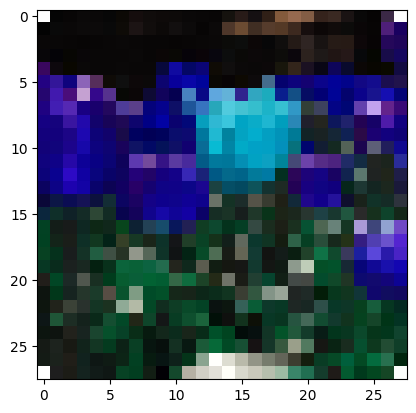

In [ ]:
# make a prediction
import matplotlib.pyplot as plt
plt.imshow(x_test[66]) # เเสดงรูปภาพออกมาดู

***นํา model ไปใช้งาน***

In [ ]:
image = x_test[66]
yhat = model.predict(np.expand_dims(image, axis=0))
print(f'Predicted: class={np.argmax(yhat)}')
print(yhat)

1/1 [==============================] - 0s 100ms/step
Predicted: class=8
[[4.1151943e-04 1.9625772e-06 6.2105753e-02 9.0783700e-02 1.3125691e-02
  1.2968765e-03 6.8102956e-02 5.0297465e-05 7.5678033e-01 7.3408936e-03]]


***Save Model to file***

In [ ]:
model.save('/content/drive/MyDrive/AI Deep Learning/AI Project/Save Model/model_flower.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
